### From Chapter 3 of Understanding Deep Learning Book

> Figure 3.3 shows the flow of computation that creates the function in figure 3.2a. Each hidden unit contains a linear function θ•0 + θ•1x of the input, and that line is clipped by the ReLU function a[•] below zero. **==The positions where the three lines cross zero become the three “joints” in the final output.==** The three clipped lines are then weighted by ϕ1, ϕ2, and ϕ3, respectively. Finally, the offset ϕ0 is added, which controls the overall height of the final function

### Figure 3.2
![figure](exercises/exer_screenshots/fig3132.png)

### Figure 3.3
![figure 3.3](exercises/exer_screenshots/fig3.3.png)

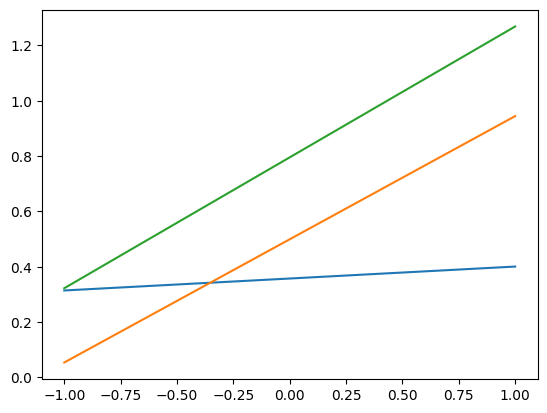

In [24]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-1.0, 1.0, num=100).reshape(-1,1)
W = np.random.rand(3,1)
b = np.random.rand(1,3)

h = X @ W.T + b

plt.plot(X.reshape(-1), h[:,0].reshape(-1), label='w1*x + b')
plt.plot(X.reshape(-1), h[:,1].reshape(-1), label='w2*x + b')
plt.plot(X.reshape(-1), h[:,2].reshape(-1), label='w3*x + b')
plt.show()


### Added stuff
- Now let's add a training loop here to observe each linear regions

In [58]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
from jaxlib.xla_extension import ArrayImpl
import math
from jax.scipy.special import logsumexp


# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (1, n))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(net_sizes, key):
  keys = random.split(key, len(net_sizes))
  return [
     random_layer_params(m, n, k) 
     for (m,n), k in zip(net_sizes, keys)
   ]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')



In [81]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, x_input):
    activations = x_input
    count = 0
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
        print(count)
        count += 1
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jnp.tanh(logits)

@jit
def loss_func(params, x_input, targets):
  preds = predict(params, x_input)
  return mse(preds, targets)

In [82]:
import numpy as np
import math

def generate_sine_data(num_samples):
  X = jnp.linspace(0, 2 * math.pi, num=num_samples).reshape(-1,1)
  y = jnp.sin(X)
  return X,y

def update_weights(params, x, y, learning_rate):
  grads = grad(loss_func)(params, x, y)
  return [(w - learning_rate * dw, b - learning_rate * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(params, num_samples, num_epochs, step_display):
  learning_rate = 0.01
  X,y = generate_sine_data(num_samples)

  for curr_epoch in range(1, num_epochs + 1):
    loss = loss_func(params, X, y)
    params = update_weights(params, X, y, learning_rate)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

def parameter_sizes(params):
  layer_depth = len(params)
  for layer_num, layer in enumerate(params, start=1):
    weight_dims = layer[0].shape
    bias_dims = layer[1].shape
    print('weights_dtype = ', layer[0].dtype)
    print('bias_dtype = ', layer[1].dtype)

    print(f'[{layer_num}/{layer_depth}] weight_dims = {weight_dims}, bias_dims = {bias_dims}')


In [83]:
# Network initial parameters
num_hidden = 10
net_sizes = [
  (1, num_hidden),
  (num_hidden, 1),
]

random_seed = np.random.randint(0, 1024)
params = init_network_params(net_sizes, random.PRNGKey(random_seed))

In [84]:
X_test, y_test = generate_sine_data(256)


In [85]:
current_epoch = 0
epoch_per_round = 10
total_epoch_rounds = 10
num_training_samples = 1024
step_display = 1

for epoch_round in range(1, epoch_per_round * total_epoch_rounds):
    params = train_network(params, num_training_samples, epoch_per_round, step_display)
    # X_test, y_test = generate_sine_data(256)
    # y_pred = predict(params, X_test)
    # loss = loss_func(params, X_test, y_test)
    # print(f'[{epoch_round}]/{total_epoch_rounds} loss = {loss}')
    
     

0
[1/10] Loss: 0.4999980330467224
[2/10] Loss: 0.4999351501464844
[3/10] Loss: 0.49987298250198364
[4/10] Loss: 0.4998112916946411
[5/10] Loss: 0.4997498393058777
[6/10] Loss: 0.4996885657310486
[7/10] Loss: 0.4996279776096344
[8/10] Loss: 0.49956923723220825
[9/10] Loss: 0.4995117783546448
[10/10] Loss: 0.4994544982910156
[1/10] Loss: 0.4993971586227417
[2/10] Loss: 0.49933964014053345
[3/10] Loss: 0.4992818534374237
[4/10] Loss: 0.4992237091064453
[5/10] Loss: 0.4991651177406311
[6/10] Loss: 0.4991059899330139
[7/10] Loss: 0.4990461468696594
[8/10] Loss: 0.4989855885505676
[9/10] Loss: 0.4989241659641266
[10/10] Loss: 0.49886178970336914
[1/10] Loss: 0.4987984299659729
[2/10] Loss: 0.4987342953681946
[3/10] Loss: 0.4986691474914551
[4/10] Loss: 0.49860262870788574
[5/10] Loss: 0.49853456020355225
[6/10] Loss: 0.49846476316452026
[7/10] Loss: 0.49839305877685547
[8/10] Loss: 0.49831926822662354
[9/10] Loss: 0.4982430934906006
[10/10] Loss: 0.4981642961502075
[1/10] Loss: 0.49808257818

In [40]:
X_test, y_test = generate_sine_data(512)



### Part 1
- Plot each linear component of initial layer.


### Sample Supblot Code

```python

import matplotlib.pyplot as plt


# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting
# Plotting with y-axis limits set

y_min = np.min(y)
y_max = np.max(y)

axs[0].plot(X_flat, y[:, 0], color='green')
axs[0].set_ylim([y_min, y_max])
axs[0].set_title('y = b_00 + w_00 * x')
axs[0].set_xlabel('X input')
axs[0].set_ylabel('y')
axs[0].set_xlim([-1, 1])

axs[1].plot(X_flat, y[:, 1], color='gray')
axs[1].set_ylim([y_min, y_max])
axs[1].set_title('y = b_01 + w_01 * x')
axs[1].set_xlabel('X input')
axs[1].set_xlim([-1, 1])

axs[2].set_xlabel('X input')
axs[2].plot(X_flat, -(y[:, 0] + y[:, 1])/2, color='black')
axs[2].set_ylim([y_min, y_max])
axs[2].set_title('y = b_02 + w_02 * x')
axs[2].set_xlim([-1, 1])

# Display the plot
fig.suptitle('Sublinear Components of Shallow Networks')
plt.show()

```